**Name:** Yidu Wu

**EID:** yiduwu2

# CS5489 - Tutorial 6
## Dimensionality Reduction and Face Recognition

In this tutorial you will use linear and non-linear dimensionality reduction on face images, and then train a classifier for face recognition. In the second part, you will then use dimensionality reduction for de-noising.

First we need to initialize Python.  Run the below cell.

In [6]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)
rbow = plt.get_cmap('rainbow')

## 1. Loading Data and Pre-processing
We first need to load the images.  Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [7]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data.astype('float')
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show an example:

(64, 64)


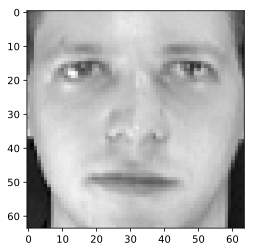

In [8]:
print(img[0].shape)
plt.imshow(img[0], cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

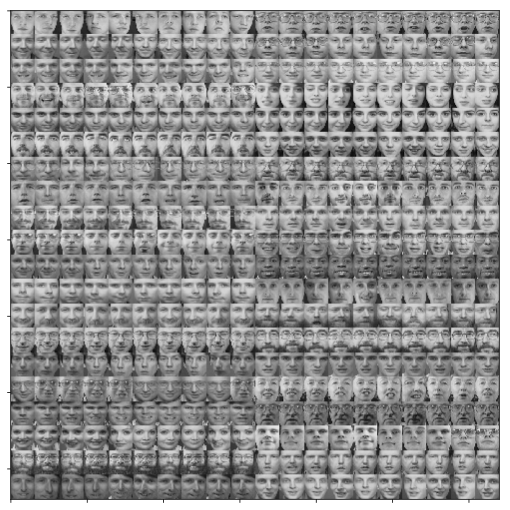

In [9]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. The class labels are in vector `Y`. Now we split the data into training and testing sets.

In [19]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


# 2. Linear Dimensionality Reduction - PCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use PCA to reduce the dimension first and then use the PCA weights as the representation for each image.  Run PCA oon the data using 9 principal components.

In [47]:
# run PCA
pca = decomposition.PCA(n_components=9)
W   = pca.fit_transform(trainX)  # returns the coefficients

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean


The below function will plot the basis vectors of PCA. Run the next 2 cells to view the PCs.

In [48]:
def plot_basis(model, imgsize):
    cname = model.__class__.__name__
    if  cname == 'LDA':
        KK = model.n_components
        comps = model.coef_
        mn    = None
    elif cname == 'PCA':
        KK = model.n_components_
        comps = model.components_
        mn    = model.mean_
    elif cname == 'NMF':
        KK = model.n_components_
        comps = model.components_
        mn    = None
    K = KK
    if mn is not None:
        K += 1        
    nr = int(ceil(K/5.0))
    sind = 1

    #vmin = comps.flatten().min()
    #vmax = comps.flatten().max()
    
    # plot the mean
    pcfig = plt.figure(figsize=(8,nr*2))
    if mn is not None:
        plt.subplot(nr,5,sind)
        plt.imshow(mn.reshape(imgsize), interpolation='nearest')
        plt.title("mean")
        plt.gray()
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])    
        sind += 1
    # plot the components
    for j in range(0,KK):
        plt.subplot(nr,5,sind)
        v = comps[j,:]            
        I = v.reshape(imgsize)
        plt.imshow(I, interpolation='nearest')
        plt.gray()
        plt.title("basis " + str(j+1))
        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        sind += 1

(320, 9)


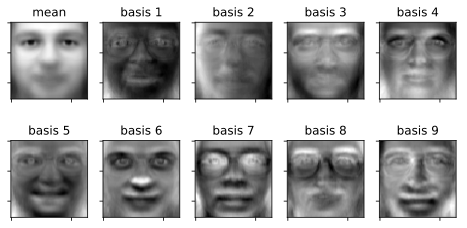

In [32]:
# run the function
plot_basis(pca, imgsize)

_What do the basis images look like? Do some basis images correspond to particular facial features?_
- **INSERT YOUR ANSWER HERE** The basis images looks like the dimension is reduced

### Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated PCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  _You do not need to do cross-validation for the number of components._  Calculate the average training and testing accuracies.  Remember to transform the test data into the PCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


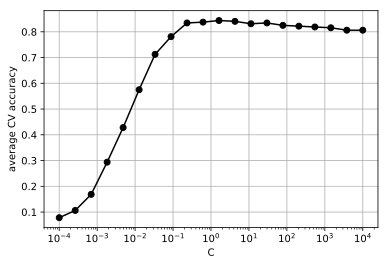

In [34]:
Wt = pca.transform(testX)
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
logreg.fit(W, trainY)
avgscores = mean(logreg.scores_[1],0)  #
plt.semilogx(logreg.Cs_, avgscores, 'ko-')
plt.xlabel('C'); plt.ylabel('average CV accuracy'); plt.grid(True);


In [35]:
predY = logreg.predict(W)
# calculate accuracy
acc = metrics.accuracy_score(trainY, predY)
print("Train accuracy=", acc)
predYtest = logreg.predict(Wt)
acc = metrics.accuracy_score(testY, predYtest)
print("test accuracy=", acc)

Train accuracy= 0.9625
test accuracy= 0.75


### Finding the best number of components
Now try a range of number of components for PCA to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plot of PCA dimension vs. test accuracy.

In [42]:
x = range(1,20,1)
Acc = []
for item in x:
    pca = decomposition.PCA(n_components=item)
    W   = pca.fit_transform(trainX)
    Wt  = pca.transform(testX)
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
    logreg.fit(W, trainY)
    predY = logreg.predict(Wt)
    acc = metrics.accuracy_score(testY, predY)
    Acc.append(acc)
print(Acc)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.1125, 0.125, 0.3125, 0.3875, 0.575, 0.65, 0.675, 0.75, 0.75, 0.825, 0.85, 0.875, 0.9, 0.9, 0.9, 0.8875, 0.925, 0.9375, 0.925]


No handles with labels found to put in legend.


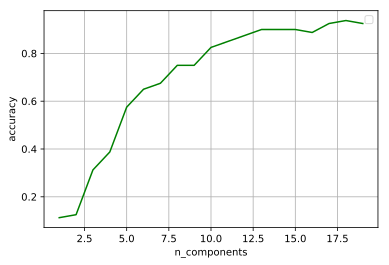

In [43]:
x = arange(1,20,1)
plt.plot(x, Acc,color='g')
plt.grid(True)
plt.legend()
plt.xlabel('n_components')
plt.ylabel('accuracy')
plt.show()


_What is the best number of components?  View the basis images to see what they look like_
- **INSERT YOUR ANSWER HERE** n_components = 18

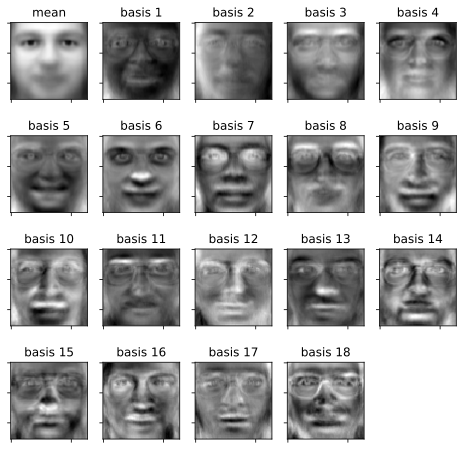

In [54]:
pca1 = decomposition.PCA(n_components=18)
W   = pca1.fit_transform(trainX)
plot_basis(pca1, imgsize)

# 3. Linear Dimensionality Reduction - NMF
Now we will repeat the experiment using non-negative matrix factorization instead of PCA.  Perform NMF with 9 components and visualize the basis images.

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


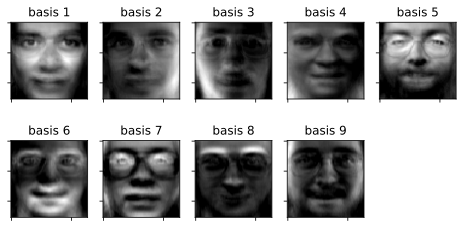

In [51]:
nmf = decomposition.NMF(n_components=9)
Wnmf = nmf.fit_transform(trainX) 
plot_basis(nmf, imgsize)

_What do the basis images look like?  What is the main difference with the PCA basis images?_
- **INSERT YOUR ANSWER HERE** It looks like not only reduce the dimension, but also extract feature.

### Finding the best number of components
Now find the number of components that gives the best test accuracy.  Use the same type of classifier that you used in the previous experiment.  Use cross-validation to select the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components.

In [52]:
x = range(1,20,1)
Acc = []
for item in x:
    nmf = decomposition.NMF(n_components=item)
    W   = nmf.fit_transform(trainX)
    Wt  = nmf.transform(testX)
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
    logreg.fit(W, trainY)
    predY = logreg.predict(Wt)
    acc = metrics.accuracy_score(testY, predY)
    Acc.append(acc)
print(Acc)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/usr/local/

[0.1, 0.1375, 0.3, 0.4375, 0.5375, 0.6, 0.7125, 0.7625, 0.7625, 0.85, 0.8, 0.8375, 0.825, 0.875, 0.8625, 0.9125, 0.9125, 0.9375, 0.9]


No handles with labels found to put in legend.


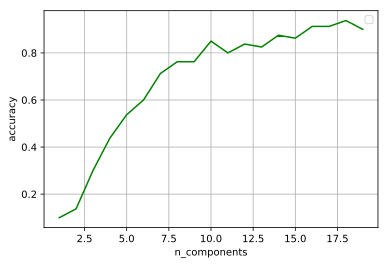

In [53]:
x = arange(1,20,1)
plt.plot(x, Acc,color='g')
plt.grid(True)
plt.legend()
plt.xlabel('n_components')
plt.ylabel('accuracy')
plt.show()

_Which number of components give the best test result? How does the accuracy compare to the best PCA result?  Why is NMF or PCA better?_
- **INSERT YOUR ANSWER HERE** 
n_components = 18.
The accuracy is better than PCA.
PCA only reduces dimension, while NMF not only reduces dimension, but also extracts features.

# Non-Linear Dimensionality Reduction - KPCA
Now we will use KPCA to perform non-linear dimensionality reduction on the data  before training the classifier.  Run KPCA on the data using 10 principal components.  Use the RBF kernel with gamma=0.001.

In [56]:
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
W = kpca.fit_transform(trainX)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [57]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

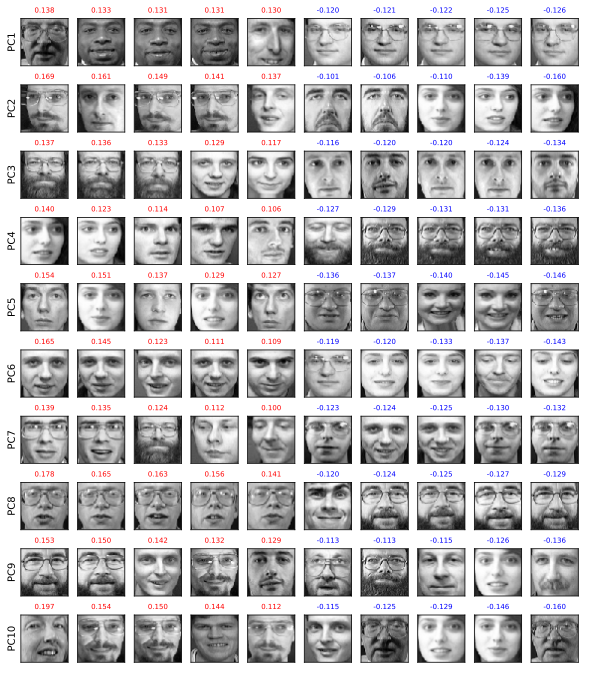

In [58]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- **INSERT YOUR ANSWER HERE** 
The PCs are modeling the differences in appearance between digits.
Top-5 positive and negative prototypes for each PC.


### Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

In [62]:
# RBF
x = range(1,20,1)
AccRBF = []
for item in x:
    kpca = decomposition.KernelPCA(n_components=item, kernel='rbf', gamma=0.001)
    W   = kpca.fit_transform(trainX)
    Wt  = kpca.transform(testX)
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-2,2,10), cv=5, n_jobs=-1)
    logreg.fit(W, trainY)
    predY = logreg.predict(Wt)
    acc = metrics.accuracy_score(testY, predY)
    AccRBF.append(acc)

In [63]:
# Poly
x = range(1,20,1)
AccPoly = []
for item in x:
    kpca = decomposition.KernelPCA(n_components=item, kernel='poly', gamma=0.001, degree=2, coef0=0)
    W   = kpca.fit_transform(trainX)
    Wt  = kpca.transform(testX)
    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-2,2,10), cv=5, n_jobs=-1)
    logreg.fit(W, trainY)
    predY = logreg.predict(Wt)
    acc = metrics.accuracy_score(testY, predY)
    AccPoly.append(acc)

No handles with labels found to put in legend.


[0.0625, 0.1375, 0.2625, 0.35, 0.525, 0.6125, 0.6625, 0.7, 0.7, 0.7, 0.7625, 0.7875, 0.8, 0.8375, 0.85, 0.85, 0.85, 0.875, 0.9]
[0.0625, 0.1375, 0.2375, 0.35, 0.5125, 0.6125, 0.65, 0.7, 0.7, 0.75, 0.8, 0.825, 0.8625, 0.8625, 0.8625, 0.875, 0.9, 0.925, 0.925]


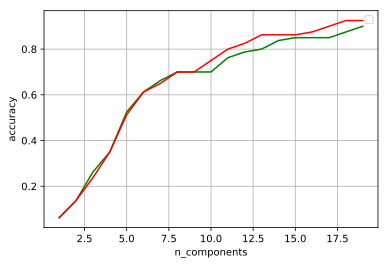

In [65]:
print(AccRBF)
print(AccPoly)
x = arange(1,20,1)
plt.plot(x, AccRBF,color='g')
plt.plot(x, AccPoly,color='r')
plt.grid(True)
plt.legend()
plt.xlabel('n_components')
plt.ylabel('accuracy')
plt.show()

_What is the best kernel and number of components?_
- **INSERT YOUR ANSWER HERE** Poly is the best kernel and best number of components = 18

*Which dimensionality reduction method performs the best for classification? Why?*
- **INSERT YOUR ANSWER HERE** NMF is the best because NMF not only reduces dimension, but also extracts features.

# De-noising with dimensionality reduction

In this section, we will  use dimensionality reduction for denoising a face image. Given a noisy image $\mathbf{x}$, we first compute the low-dimensional representation $\mathbf{w}$, e.g., using PCA. Then given $\mathbf{w}$, we reconstruct the image $\hat{\mathbf{x}}$ from the PCA/NMF basis.  In sklearn, the reconstruction step can be achieved using the `inverse_transform()` method of the PCA or NMF classes.

Train a PCA or NMF model using a large number of components (e.g., 100) on the face dataset, and then test it for denoising. For the noisy images, you can try different types of noise, such as:
- additive noise (using `random.normal`)
- salt & pepper noise (using `random.binomial`)
- masking out part of the image (the masked out part can be replaced with black, gray, or white).


for evaluation of the reconstruction or denoising result you can use "peak signal to noise ratio", which is implemented in skimage as `skimage.metrics.peak_signal_noise_ratio` or `skimage.measure.compare_psnr` (on older versions).

In [73]:
import skimage

In [96]:
noisyX = trainX + 2*random.normal(size=trainX.shape)
noisyXt = testX + 2*random.normal(size=testX.shape)

# learn PCA
pca = decomposition.PCA(n_components=100)
pca.fit(noisyX)  # fit the training set

# transform and reconstuct
testW = pca.transform(noisyXt)
testXr = pca.inverse_transform(testW)   

In [100]:
skimage.measure.compare_psnr(testX,testXr)

8.878618841220721

In [103]:
noisyX = trainX + random.binomial(10,1,size=trainX.shape)
noisyXt = testX + random.binomial(10,1,size=testX.shape)

# learn PCA
pca = decomposition.PCA(n_components=100)
pca.fit(noisyX)  # fit the training set

# transform and reconstuct
testW = pca.transform(noisyXt)
testXr = pca.inverse_transform(testW) 
skimage.measure.compare_psnr(testX,testXr)

-20.000160210071662

In [105]:
noisyX = trainX + 2*random.random()
noisyXt = testX + 2*random.random()
# learn PCA
pca = decomposition.PCA(n_components=100)
pca.fit(noisyX)  # fit the training set

# transform and reconstuct
testW = pca.transform(noisyXt)
testXr = pca.inverse_transform(testW) 
skimage.measure.compare_psnr(testX,testXr)

-0.9192659200498534

_Which kind of noise can be handled well by linear dimensionality reduction? Why?_
- **INSERT YOUR ANSWER HERE** Additive noise can be handled well